# 0) Setup

In [1]:
import pandas as pd, numpy as np
from pathlib import Path
import fsspec

S3_STATIONS_TXT   = "s3://noaa-ghcn-pds/ghcnd-stations.txt"
S3_INVENTORY_TXT  = "s3://noaa-ghcn-pds/ghcnd-inventory.txt"
S3_BY_STATION     = "s3://noaa-ghcn-pds/csv/by_station/{id}.csv"
STOR = {"anon": True}


OUTDIR = Path('../data'); OUTDIR.mkdir(parents=True, exist_ok=True)
OUT_PARQUET = OUTDIR / 'ghcn_DE_daily.parquet'
OUT_CSV = OUTDIR / 'ghcn_DE_daily.csv'
print('Output:', OUT_PARQUET.resolve())

Output: /home/alissah3/test/data/ghcn_DE_daily.parquet


In [2]:
colspecs = [(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,75),(76,79),(80,85)]
names = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME','GSN_FLAG','HCN_CRN_FLAG','WMO_ID']

stations = pd.read_fwf(S3_STATIONS_TXT, colspecs=colspecs, names=names, dtype={'ID':str,'STATE':str,'WMO_ID':str}, storage_options=STOR)
stations['NAME'] = stations['NAME'].str.strip(); stations['STATE'] = stations['STATE'].fillna('').str.strip()

inventory = pd.read_csv(
    S3_INVENTORY_TXT, sep=r'\s+', names=['ID','LAT','LON','ELEMENT','FIRSTYEAR','LASTYEAR'],
    dtype={'ID':str,'ELEMENT':str,'FIRSTYEAR':int,'LASTYEAR':int}, engine='python', storage_options=STOR
)

stations.head(), inventory.head()

(            ID  LATITUDE  LONGITUDE  ELEVATION STATE                   NAME  \
 0  ACW00011604   17.1167   -61.7833       10.1        ST JOHNS COOLIDGE FLD   
 1  ACW00011647   17.1333   -61.7833       19.2                     ST JOHNS   
 2  AE000041196   25.3330    55.5170       34.0          SHARJAH INTER. AIRP   
 3  AEM00041194   25.2550    55.3640       10.4                   DUBAI INTL   
 4  AEM00041217   24.4330    54.6510       26.8               ABU DHABI INTL   
 
   GSN_FLAG HCN_CRN_FLAG WMO_ID  
 0      NaN          NaN    NaN  
 1      NaN          NaN    NaN  
 2      GSN          NaN  41196  
 3      NaN          NaN  41194  
 4      NaN          NaN  41217  ,
             ID      LAT      LON ELEMENT  FIRSTYEAR  LASTYEAR
 0  ACW00011604  17.1167 -61.7833    TMAX       1949      1949
 1  ACW00011604  17.1167 -61.7833    TMIN       1949      1949
 2  ACW00011604  17.1167 -61.7833    PRCP       1949      1949
 3  ACW00011604  17.1167 -61.7833    SNOW       1949      194

In [3]:
coverage = (inventory.groupby('ID', as_index=False)
                    .agg(first=('FIRSTYEAR','min'), last=('LASTYEAR','max'))
                    .assign(years=lambda d: d['last'] - d['first'] + 1))

de = (stations.loc[stations['STATE']=='DE', ['ID','NAME','STATE','LATITUDE','LONGITUDE','ELEVATION']]
              .merge(coverage, on='ID', how='inner'))

              
de_1991_2020 = de[(de['first'] <= 1991) & (de['last'] >= 2020)].copy()
de_1991_2020.sort_values(['years','ID'], ascending=[False, True]).head()

,ID,NAME,STATE,LATITUDE,LONGITUDE,ELEVATION,first,last,years
127,USC00072730,DOVER,DE,39.1467,-75.5056,9.1,1893,2025,133
138,USC00076410,NEWARK AG FARM,DE,39.6683,-75.7456,32.3,1894,2025,132
143,USC00079605,WILMINGTON PORTER RSCH,DE,39.7739,-75.5414,82.3,1931,2025,95
147,USW00013781,WILMINGTON NEW CASTLE CO AP,DE,39.6744,-75.6056,22.6,1931,2025,95
132,USC00075320,LEWES,DE,38.7842,-75.1581,3.0,1945,2025,81


In [4]:
fs = fsspec.filesystem('s3', **STOR)
candidates = de_1991_2020.sort_values(['years','ID'], ascending=[False, True])['ID'].tolist()
picked, url_map = [], {}
for sid in candidates:
    url = S3_BY_STATION.format(id=sid)
    if fs.exists(url):
        picked.append(sid); url_map[sid] = url
    if len(picked)>=2: break
print('Picked:', picked)
url_map

Picked: ['USC00072730', 'USC00076410']


{'USC00072730': 's3://noaa-ghcn-pds/csv/by_station/USC00072730.csv',
 'USC00076410': 's3://noaa-ghcn-pds/csv/by_station/USC00076410.csv'}

# 1) GHCN Daily Data

In [5]:
def download_station(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)
    wide = (df.pivot_table(index=['ID','DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index())
    for c in ('TMAX','TMIN','TAVG'):
        if c in wide: wide[c] = wide[c]/10.0
    if 'PRCP' in wide: wide['PRCP'] = wide['PRCP']/10.0
    return wide.sort_values(['ID','DATE']).reset_index(drop=True)

frames = []
for sid in picked:
    w = download_station(url_map[sid])
    frames.append(w); print(sid, w.shape)

daily = pd.concat(frames, ignore_index=True)
daily.head()

/tmp/ipykernel_27647/2798440478.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])


USC00072730 (43676, 22)
USC00076410 (30434, 27)


/tmp/ipykernel_27647/2798440478.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])


ELEMENT,ID,DATE,DAPR,DASF,MDPR,MDSF,PRCP,SNOW,SNWD,TMAX,...,WT16,WT18,DAEV,DAWM,EVAP,MDEV,MDWM,MNPN,MXPN,WDMV
0,USC00072730,1893-01-01,NaN,NaN,NaN,NaN,21.8,0.0,NaN,12.2,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00072730,1893-01-02,NaN,NaN,NaN,NaN,0.0,0.0,NaN,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00072730,1893-01-03,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00072730,1893-01-04,NaN,NaN,NaN,NaN,0.0,0.0,NaN,-3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00072730,1893-01-05,NaN,NaN,NaN,NaN,0.0,0.0,NaN,-2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def station_stats(df: pd.DataFrame) -> pd.DataFrame:
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.dropna(subset=['ID','TMAX', 'TMIN'])
    df['year'] = df['DATE'].dt.year

    record_max_temp = df['TMAX'].max()
    record_min_temp = df['TMIN'].min()

    mask = (df['year'] >= 1991) & (df['year'] <= 2020)
    filtered = df[mask]

    average_max_temp = filtered['TMAX'].mean()
    average_min_temp = filtered['TMIN'].mean()

    stats = pd.DataFrame({
        'record_max_temp': [record_max_temp],
        'record_min_temp': [record_min_temp],
        'average_max_temp': [average_max_temp],
        'average_min_temp': [average_min_temp],
    })
    return stats

In [7]:
summary = station_stats(daily)
print('Station ID:', picked)
print(summary)

Station ID: ['USC00072730', 'USC00076410']
   record_max_temp  record_min_temp  average_max_temp  average_min_temp
0             40.6            -30.0          19.03951          8.292823


/tmp/ipykernel_27647/731312780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['DATE'].dt.year


# 2) Plot

In [10]:
daily['year'] = daily['DATE'].dt.year
DOV_2018 = daily[daily['year'] == 2018].copy()
DOV_2018['month'] = DOV_2018['DATE'].dt.month

# Calculate month average
monthly_avg = DOV_2018.groupby('month')[['TMAX', 'TMIN']].mean().reset_index()
month_days = DOV_2018.groupby('month')['DATE'].agg(['min','max']).reset_index()

# Calculate yearly records
rec_max_2018 = DOV_2018['TMAX'].max()
rec_min_2018 = DOV_2018['TMIN'].min()

# Find dates for yearly records
rec_max_date_2018 = DOV_2018.loc[DOV_2018['TMAX'] == rec_max_2018, 'DATE'].values[0]
rec_min_date_2018 = DOV_2018.loc[DOV_2018['TMIN'] == rec_min_2018, 'DATE'].values[0]

Text(0.5, 1.0, '2018 Dover, Delaware Temperature')

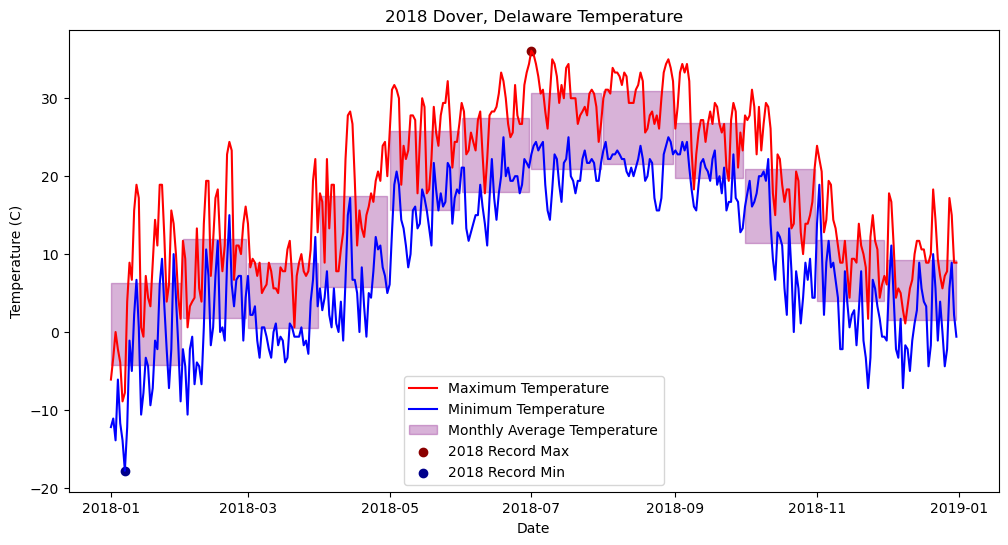

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(DOV_2018['DATE'],DOV_2018['TMAX'], color = 'red', label = 'Maximum Temperature')
plt.plot(DOV_2018['DATE'], DOV_2018['TMIN'], color = 'blue', label = 'Minimum Temperature')

label = False
for i, row in month_days.iterrows():
    month = row['month']
    start, end = row['min'], row['max']
    avg_max = monthly_avg.loc[monthly_avg['month'] == month, 'TMAX'].values[0]
    avg_min = monthly_avg.loc[monthly_avg['month'] == month, 'TMIN'].values[0]
    if not label:
        plt.fill_between(pd.date_range(start, end), avg_min, avg_max,
                         color='purple', alpha=0.3, label='Monthly Average Temperature')
        label = True
    else:
        plt.fill_between(pd.date_range(start, end), avg_min, avg_max,
                         color='purple', alpha=0.3)


plt.scatter(rec_max_date_2018, rec_max_2018, color='darkred', label='2018 Record Max')
plt.scatter(rec_min_date_2018, rec_min_2018, color='darkblue', label='2018 Record Min')


plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('2018 Dover, Delaware Temperature')